<a href="https://colab.research.google.com/github/wldud01/DLthon/blob/main/BERT_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wandb==0.16.0

In [1]:
import os
import pandas as pd

train_data_path = "train.csv"
train_data = pd.read_csv(train_data_path)
train_data.head()

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [2]:

df_al = train_data
df_al.loc[ df_al['class']=='협박 대화', 'idx'] = 0
df_al.loc[ df_al['class']=='기타 괴롭힘 대화', 'idx'] = 3
df_al.loc[ df_al['class']=='갈취 대화', 'idx'] = 1
df_al.loc[ df_al['class']=='직장 내 괴롭힘 대화', 'idx'] = 2

df_al

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,0,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,3,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,1,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,1,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...
...,...,...,...
3945,3,기타 괴롭힘 대화,준하야 넌 대가리가 왜이렇게 크냐?\n내 머리가 뭐.\n밥먹으면 대가리만 크냐 너는...
3946,1,갈취 대화,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내\n예.?...
3947,2,직장 내 괴롭힘 대화,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지.\n왜 그래. 들리겠어...
3948,1,갈취 대화,누구맘대로 여기서 장사하래?\n이게 무슨일입니까?\n남의 구역에서 장사하려면 자릿세...


In [4]:
df_al=df_al.rename(columns={'idx':'label','conversation':'text'}).drop('class',axis=1)

In [7]:
# 필요한 라이브러리 추가
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
import torch
# 훈련 데이터셋과 테스트 데이터셋으로 분할
train_df, test_df = train_test_split(df_al, test_size=0.2, random_state=42)

# Load the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('distilbert-base-cased')
model = BertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=len(df_al['label'].unique()))

# 사용자 정의 데이터셋 클래스
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = self.dataframe.iloc[idx]['text']
        label = self.dataframe.iloc[idx]['label']
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# 데이터셋 인스턴스 생성
train_dataset = CustomDataset(train_df, tokenizer)
test_dataset = CustomDataset(test_df, tokenizer)

# DataLoader 설정
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)


# 옵티마이저 설정
optimizer = AdamW(model.parameters(), lr=5e-5)

# WandB sweep 설정
sweep_config = {
    "name": "sweep_test",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "method": "random",
    "parameters": {
        "learning_rate": {
            "min": 0.0001,
            "max": 0.005
        },
        "epoch": {
            "distribution": "int_uniform",
            "min": 2,
            "max": 4
        }
    }
}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceCl

In [8]:
import wandb
wandb.login(key = 'Your token')

wandb: Currently logged in as: yunjiyeong0106. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [10]:
import wandb
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score

# Define your validation dataset and dataloader
# Assuming you have a validation_dataset and validation_dataloader

def train():
    # Default configuration for WandB
    default_config = {
        "learning_rate": 0.005,
        "epoch": 3,
        "batch_size": 16
    }

    # Initialize WandB
    wandb.init(config=default_config)
    config = wandb.config

    # Training loop
    for epoch in range(config.epoch):
        model.train()
        total_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for batch_idx, batch in enumerate(train_dataloader):
            inputs = {
                "input_ids": batch["input_ids"],
                "attention_mask": batch["attention_mask"],
                "labels": batch["label"],
            }

            outputs = model(**inputs)
            loss = outputs.loss
            total_loss += loss.item()

            # 정확도 계산
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)
            correct_predictions += (predictions == batch["label"]).sum().item()
            total_samples += len(batch["label"])

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()


            # Compute accuracy
            predictions = torch.argmax(logits, dim=1)
            correct_predictions += (predictions == batch["label"]).sum().item()
            total_samples += len(batch["label"])

            # Log every 10 batches
            if (batch_idx + 1) % 10 == 0:
                average_loss = total_loss / (batch_idx + 1)
                accuracy = correct_predictions / total_samples

                # Log metrics to WandB
                wandb.log({"Epoch": epoch + 1, "Batch": batch_idx + 1, "Training Loss": average_loss, "Training Accuracy": accuracy})

        # Log metrics for the entire epoch
        average_loss = total_loss / len(train_dataloader)
        accuracy = correct_predictions / total_samples
        wandb.log({"Epoch": epoch + 1, "Training Loss": average_loss, "Training Accuracy": accuracy})
        torch.save(model.state_dict(), f'PyModel{batch}.sd')

        # Validation loop
        model.eval()
        val_predictions, val_true_labels = [], []
        with torch.no_grad():
            for val_batch in test_dataloader:
                val_inputs = {
                    "input_ids": val_batch["input_ids"],
                    "attention_mask": val_batch["attention_mask"],
                    "labels": val_batch["label"],
                }
                val_outputs = model(**val_inputs)
                val_predictions.extend(torch.argmax(val_outputs.logits, dim=1).cpu().numpy())
                val_true_labels.extend(val_batch["label"].cpu().numpy())

        val_accuracy = accuracy_score(val_true_labels, val_predictions)
        wandb.log({"Epoch": epoch + 1, "Validation Accuracy": val_accuracy})



In [11]:
# Make sure to replace <<YOUR ENTITY NAME>> and <<YOUR PROJECT NAME>> with your Wandb entity and project names
sweep_id = wandb.sweep(sweep_config,
                       entity="yunjiyeong0106",
                       project="aiffel")

# Run the sweep
wandb.agent(sweep_id, function=train, count=10)


Create sweep with ID: 3ek8mii3
Sweep URL: https://wandb.ai/yunjiyeong0106/aiffel/sweeps/3ek8mii3


wandb: Agent Starting Run: j0i5nz50 with config:
wandb: 	epoch: 4
wandb: 	learning_rate: 0.00040382725951005233


wandb: Ctrl + C detected. Stopping sweep.


In [16]:
torch.save(model.state_dict(),'PyModel1.sd')

In [2]:
import json
import pandas as pd

path = "test.json"
# Create a list to store input texts
df = pd.read_json(path).transpose()
df.head()

,text
t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...
t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...
t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
t_003,이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 ...
t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...


In [3]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
import pandas as pd

# Load the saved model state dictionary
model_state_dict = torch.load('PyModel1.sd')  # Change '123' to the appropriate batch number

# Initialize the model architecture
model = BertForSequenceClassification.from_pretrained("klue/bert-base", num_labels=4)
# Load the model state dictionary
model.load_state_dict(model_state_dict)
# Load the pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained("klue/bert-base")
#model = BertForSequenceClassification.from_pretrained("klue/bert-base", num_labels=4)

# Assuming df is your DataFrame with a 'text' column
texts = df['text']

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
        }

# Create an instance of the custom dataset
test_dataset = CustomDataset(texts, tokenizer)

# Create DataLoader instance
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Make predictions
predictions = []

for test_batch in test_dataloader:
    test_inputs = {
        "input_ids": test_batch["input_ids"],
        "attention_mask": test_batch["attention_mask"]
    }
    test_outputs = model(**test_inputs)
    predictions.extend(torch.argmax(test_outputs.logits, dim=1).cpu().numpy())

# Add predictions to the DataFrame
df['predicted_label'] = predictions

# Now, df contains the predicted labels in the 'predicted_label' column
df[['text', 'predicted_label']]


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


,text,predicted_label
t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...,3
t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...,3
t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...,3
t_003,이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 ...,3
t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...,3
...,...,...
t_495,미나씨 휴가 결제 올리기 전에 저랑 상의하라고 말한거 기억해요? 네 합니다. 보고서...,3
t_496,교수님 제 논문에 제 이름이 없나요? 아 무슨 논문말이야? 지난 번 냈던 논문이...,3
t_497,야 너 네 저요? 그래 너 왜요 돈좀 줘봐 돈 없어요 돈이 왜 없어 지갑은 폼이...,3
t_498,야 너 빨리 안 뛰어와? 너 이 환자 제대로 봤어 안 봤어 어제 저녁부터 계속 보다...,3


In [15]:
df_result = df.drop('text',axis =1)
df_result.rename(columns={'predicted_label':'class'}).reset_index().rename(columns={'index':'file_name'}).to_csv('predictions1.csv', index=False)

### EDA

문장의 최단 길이: 41
문장의 최장 길이: 874
문장의 평균 길이: 226


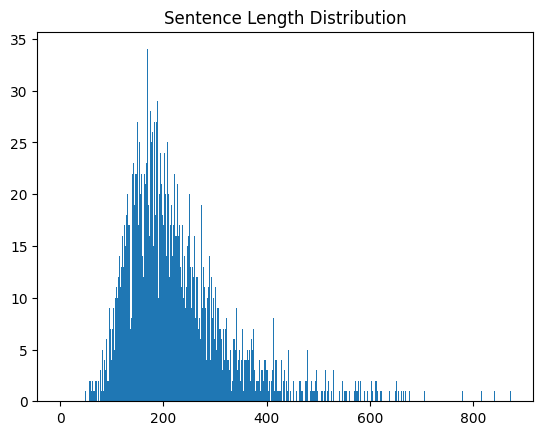

In [14]:
sum_len = 0
import numpy as np
import matplotlib.pyplot as plt

min_len = 100000
max_len = 0

for sen in df_al['text'].values:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(df_al['text'].values))

sentence_length = np.zeros((max_len), dtype=int)

for sen in df_al['text'].values:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

<AxesSubplot:xlabel='label'>

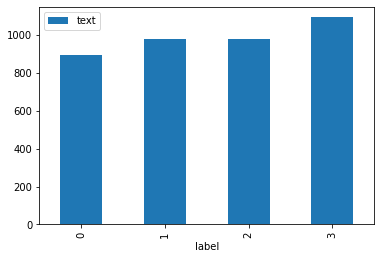

In [ ]:
df_al.groupby('label').count().plot.bar()

In [11]:
df_al['text'].nunique()

3846

In [ ]:
# 중복데이터 확인
print(len(df_al['text']))
print(df_al['text'].nunique())

3950
3846
